# Training Pipeline

# Imports
## Pip Packages

In [1]:
import os
from torch.utils.data import DataLoader

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)

from tqdm import tqdm

from src.parsers import CocoFreeView
from src.preprocess.simulation import gen_gaze, downsample
from src.preprocess.noise import add_random_center_correlated_radial_noise
from src.datasets import FreeViewInMemory, seq2seq_padded_collate_fn, seq2seq_jagged_collate_fn

# Load Dataset

In [2]:
# TODO Implement Strategy and Builder pattern
datasetv2 = FreeViewInMemory(sample_size= 8,log = True, start_index=2)


Data loaded in memory


## Speed Test

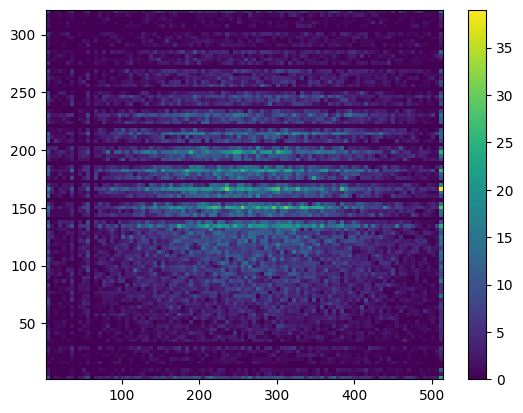

In [3]:
import matplotlib.pyplot as plt

# for i in tqdm(range(len(datasetv2))):
acum_x = []
acum_y = []
for i in range(len(datasetv2)):
    x,y = datasetv2[i]
    acum_x.append(x[0,0])
    acum_y.append(x[1,0])


plt.hist2d(acum_x, acum_y, bins=100)
plt.colorbar()
plt.show()


In [4]:


dataloader = DataLoader(datasetv2, batch_size=128, shuffle=True, num_workers=0, collate_fn= seq2seq_jagged_collate_fn)
for batch in tqdm(dataloader):
    x,y = batch
    break

  0%|          | 0/274 [00:01<?, ?it/s]


In [6]:
# dataset = PathCocoFreeViewDatasetBatch(sample_size= 8,log = True)
# dataset.close_and_remove_data()

# dataset.close_and_remove_data()
# dataset.shuffle_dataset()


# for i in tqdm(range(len(dataset))):
#     dataset[i]

# Transformer Model
## Eye-tracking Sequence Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadedAttention(nn.Module):
    def __init__(self,model_dim, head_dim ,n_heads, is_self_attention = False, is_causal = False):
        super().__init__()
        self.model_dim = model_dim
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.is_self_attention = is_self_attention
        self.is_causal = is_causal

        total_dim = n_heads*head_dim
        if is_self_attention:
            self.proj_in = nn.Linear(model_dim,total_dim*3, bias = False)
        else:
            self.proj_q = nn.Linear(model_dim,total_dim, bias = False)
            self.proj_kv = nn.Linear(model_dim, total_dim * 2, bias = False)
        self.proj_out = nn.Linear(total_dim,model_dim, bias = False)
    
    def forward(self,query, key = None):
        # in_proj
        if self.is_self_attention:
            result = self.proj_in(query)
            query, key, value = torch.chunk(result, 3,dim = -1)
        else:
            query = self.proj_q(query)
            result = self.proj_kv(key)
            key, value = torch.chunk(result, 2,dim = -1)
        # reshape
        # (B,L_seq, total_dim) -> (B, L_seq, n_heads, head_dim) -> (B, n_heads, L_seq, head_dim)
        query = query.unflatten(-1,[self.n_heads, self.head_dim]).transpose(1,2)
        key = key.unflatten(-1,[self.n_heads, self.head_dim]).transpose(1,2)
        value = value.unflatten(-1,[self.n_heads, self.head_dim]).transpose(1,2)
        # scaled dot product
        attn_output = F.scaled_dot_product_attention(query, key, value,is_causal= self.is_causal)
        # (B, n_heads, L_seq, head_dims)
        attn_output = attn_output.transpose(1,2).flatten(-2)
        # (B, L_seq, total)
        attn_output = self.proj_out(attn_output)
        return attn_output 

class Transformer_Encoder(nn.Module):
    def __init__(self):
        super().__init__()


class Transformer(nn.Module):
    def __init__(self, encoder_layers = 6, decoder_layers = 6):
        super().__init__()
        self.encoder_layers = 6
        self.decoder_layers = 6
        nn.Sequential()

